In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={"figure.dpi":1200})
sns.set_context('notebook')
sns.set_style("ticks")

mpl.style.use('default')

# Update rcParams for global consistency
mpl.rcParams.update({
    'axes.linewidth': 7,           # Line width for axes
    'xtick.major.size': 20,        # Major tick size
    'xtick.major.width': 7,        # Major tick width
    'xtick.minor.size': 10,        # Minor tick size
    'xtick.minor.width': 7,        # Minor tick width
    'ytick.major.size': 20,        # Major tick size
    'ytick.major.width': 7,        # Major tick width
    'ytick.minor.size': 10,        # Minor tick size
    'ytick.minor.width': 7,        # Minor tick width
    'ytick.labelsize': 60,         # Label size for y ticks
    'xtick.labelsize': 60,         # Label size for x ticks
    'font.size': 60,               # Font size for text
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial',
    'mathtext.bf': 'Arial:bold',
    'lines.linewidth': 7,          # Line width for all lines
    'scatter.marker': 'o',         # Default marker for scatter
    'lines.markersize': 10,        # Marker size for scatter in points
    'axes.titlesize': 'large',     # Title size
    'axes.labelsize': 'large',     # Label size for axes
    'legend.fontsize': 'large'     # Font size for legends
})


In [43]:
###IMPORT DATAFRAME###
df1 = pd.read_csv('../BASAL_HIF1A_CITED2_MASTER.csv',index_col=0)
df1['mut name'] = df1['mut name'].replace('FML>A', 'FL>A')
#df = df.drop('Unnamed: 0', axis=1)

# Drop any rows where 'protein' is 'HIF1A'
df = df1[df1['protein'] != 'HIF1A']

# Print out a list of the unique 'mut name' values
unique_mut_names = df['mut name'].unique()

In [44]:
###FILTERS
df_filtered=df
df_filtered = df_filtered[(df_filtered['area']<10000)]
df_filtered = df_filtered[(df_filtered['log directA']>3.1)]
df_filtered = df_filtered[(df_filtered['log directA']<3.9)]
###KEEP ONLY CONSTRUCTS WITH 
# Group by 'ID' and get 'well' value counts for each group
grouped_well_counts = df.groupby('ID')['well'].value_counts()

# Convert the Series to a DataFrame for easier filtering
grouped_well_counts = grouped_well_counts.reset_index(name='count')

# Identify 'ID' and 'well' pairs with a count of 30 or more
valid_wells = grouped_well_counts[grouped_well_counts['count'] >= 30]

# Merge the valid_wells DataFrame back with the original df to filter it
# Only keep rows from df that have 'ID' and 'well' combinations appearing in valid_wells
df_filtered = df.merge(valid_wells[['ID', 'well']], on=['ID', 'well'])

# The df_filtered now contains only the rows from the original df where the 'well' count per 'ID' is 30 or more
#df=df_filtered


In [45]:
# Calculating the median value for each unique well value for each mut name
stats = df.groupby(['mut name', 'well'])['Ef'].median().reset_index()

# Renaming the median column for clarity
stats.rename(columns={'Ef': 'Median Ef'}, inplace=True)

# Group by 'mut name' and calculate the average and standard deviation of the median 'Ef' values
avg_std_median_ef = stats.groupby('mut name')['Median Ef'].agg(['mean', 'std']).reset_index()

# Renaming the columns for clarity
avg_std_median_ef.rename(columns={'mean': 'Average Median Ef', 'std': 'Std Dev Median Ef'}, inplace=True)

print(avg_std_median_ef)

        mut name  Average Median Ef  Std Dev Median Ef
0      ED>A0to20           0.242771           0.031592
1           FL>A           0.487108           0.013414
2            L>F           0.573933           0.006814
3            L>W           0.617334           0.017539
4  RK>Amut20to39           0.591816           0.011250
5           RK>E           0.576019           0.008595
6             WT           0.606845           0.018201


In [47]:
# Step 1: Group by 'well' and 'mut name', then calculate the median for each group
medians_by_well = df.groupby(['well', 'mut name'])['Ef'].median().reset_index(name='median_Ef')

# Step 2: Calculate the average and standard deviation of these medians for each 'mut name'
stats_by_mut_name = medians_by_well.groupby('mut name')['median_Ef'].agg(
    avg_median='mean',
    std_dev_median='std'
).reset_index()

#print(stats_by_mut_name)

In [33]:
from scipy.stats import ttest_ind_from_stats
# Assuming 'stats' DataFrame contains 'Median Ef' for each 'mut name' and 'well'
# Example stats DataFrame
# Calculate the mean and standard deviation of 'Median Ef' for each 'mut name'
stats_summary = stats.groupby('mut name')['Median Ef'].agg(['mean', 'std'])

# Extracting the mean and std median Ef value for 'WT'
wt_mean, wt_std = stats_summary.loc['WT']

# Initialize a DataFrame to store the results
t_test_results = pd.DataFrame(columns=['mut name', 'p-value', 'asterisk'])

# Perform t-tests comparing the mean Median Ef of each mut name against the WT
for mut_name, row in stats_summary.iterrows():
    if mut_name != 'WT':
        # Extract mean and standard deviation for the current 'mut name'
        mut_mean, mut_std = row

        # Calculate the standard errors
        wt_se = wt_std / np.sqrt(len(stats[stats['mut name'] == 'WT']))
        mut_se = mut_std / np.sqrt(len(stats[stats['mut name'] == mut_name]))

        # T-test
        t_stat, p_value = ttest_ind_from_stats(mut_mean, mut_se, len(stats[stats['mut name'] == mut_name]),
                                               wt_mean, wt_se, len(stats[stats['mut name'] == 'WT']),
                                               equal_var=False)
        
        # Determine the asterisk
        asterisk = ''
        if p_value < 0.0001:
            asterisk = '***'
        elif p_value < 0.001:
            asterisk = '**'
        elif p_value < 0.01:
            asterisk = '*'
        
        # Create a temporary DataFrame with the results
        temp_df = pd.DataFrame({'mut name': [mut_name], 'p-value': [p_value], 'asterisk': [asterisk]})
        
        # Concatenate the result to the main DataFrame
        t_test_results = pd.concat([t_test_results, temp_df], ignore_index=True)

t_test_results  # Display the first few rows of the results DataFrame

,mut name,p-value,asterisk
0,ED>A0to20,1.035992e-03,*
1,FL>A,1.219033e-08,***
2,L>F,2.505198e-06,***
3,L>W,1.527903e-01,
4,RK>Amut20to39,4.944084e-03,*
5,RK>E,4.178323e-06,***


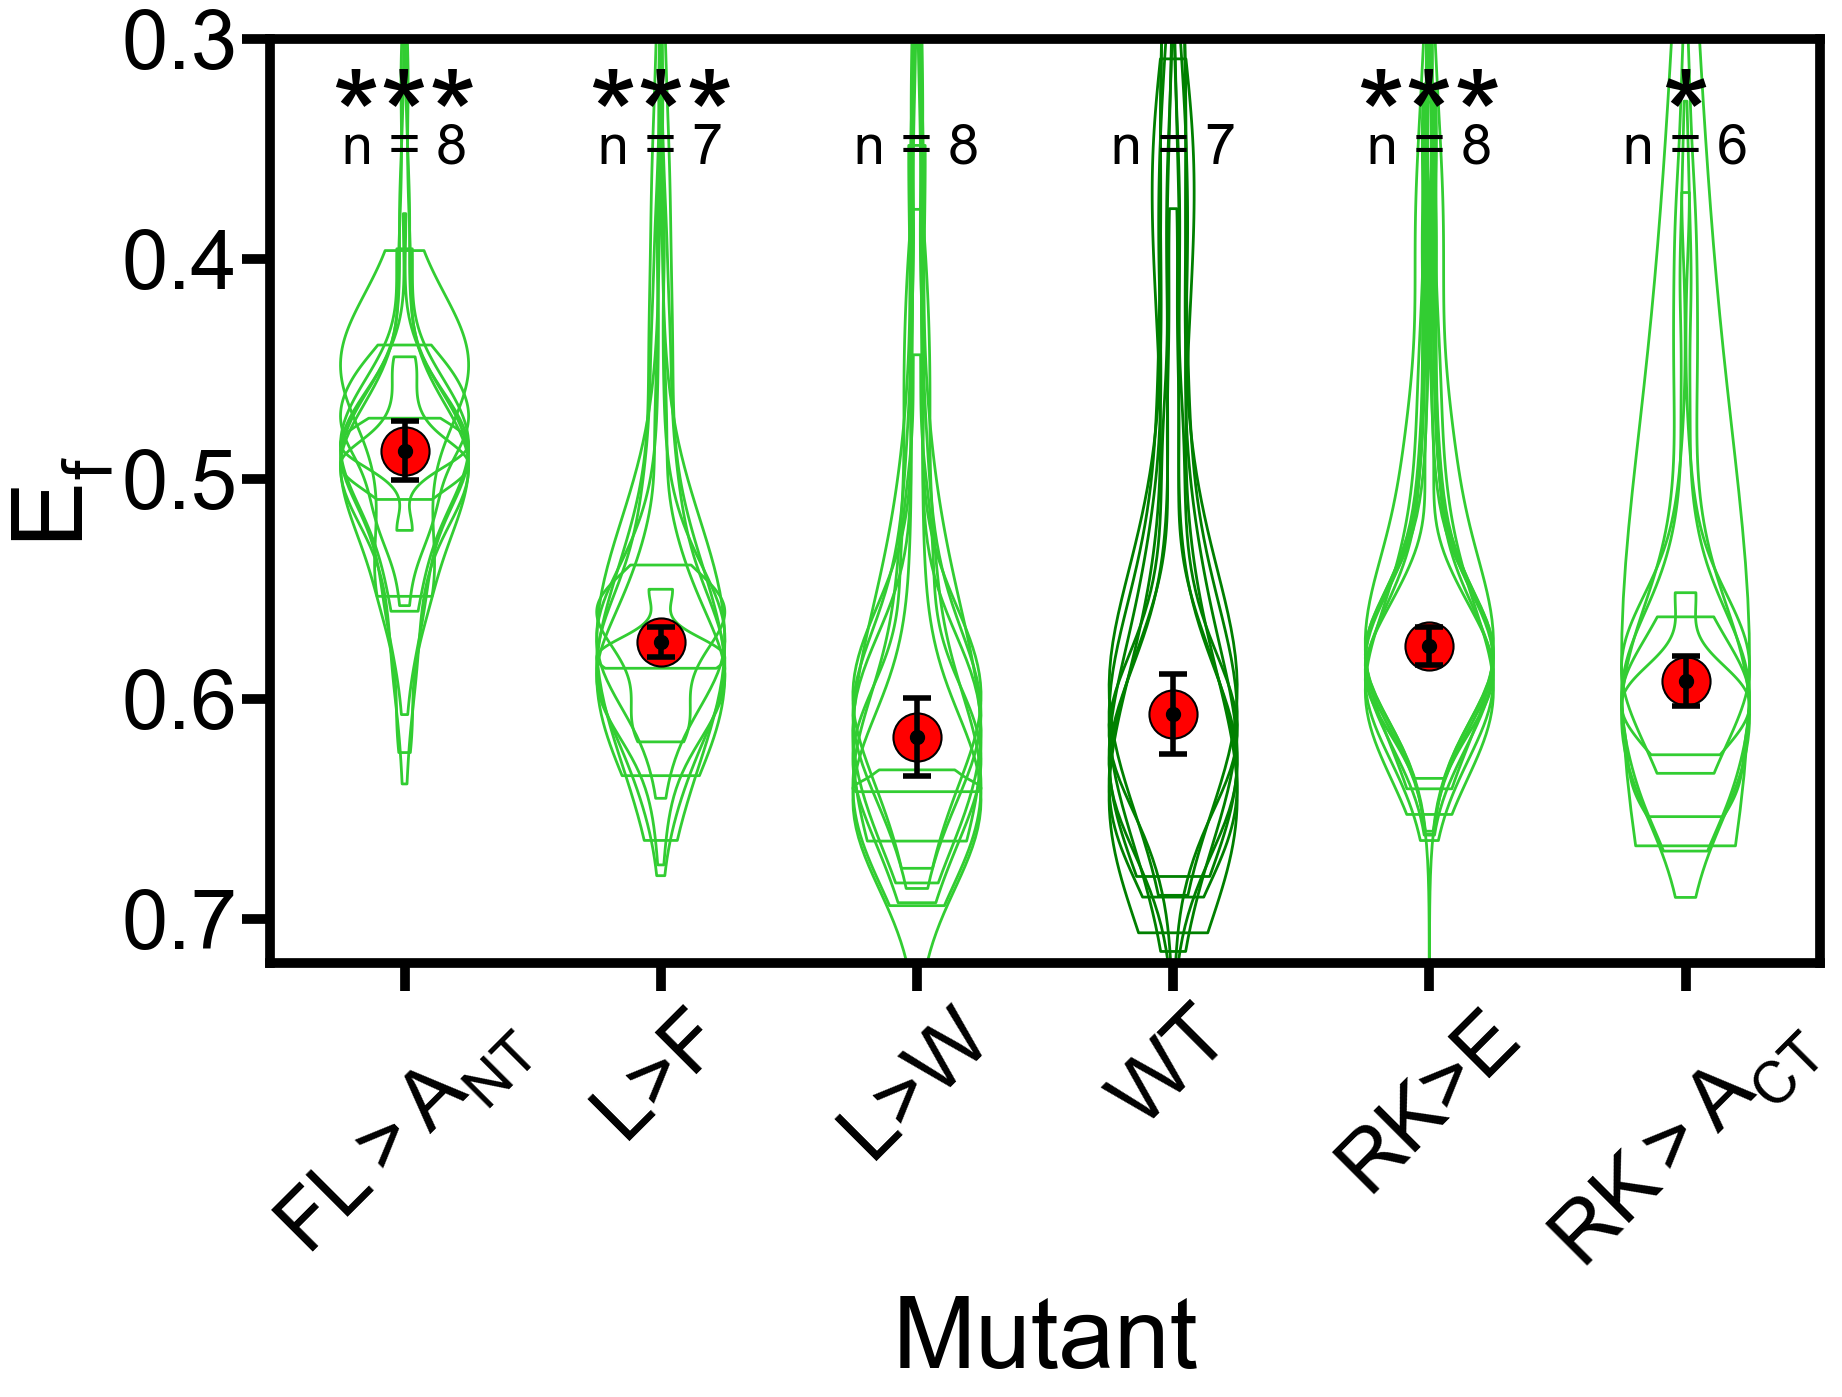

In [48]:
# Specified mutants in the desired order
mut_names = ['FL>A', 'L>F', 'L>W', 'WT', 'RK>E', 'RK>Amut20to39']

# Unique well values
well_values = df['well'].unique()

# Create a figure instance and adjust the size
fig, ax = plt.subplots(figsize=(20, 12))

# Iterate over each mutation name for violin plots
for i, mut in enumerate(mut_names):
    # For each mutation, iterate over each well value
    for well in well_values:
        # Filter data for each mutation and well
        data = df[(df['mut name'] == mut) & (df['well'] == well)]['Ef']
        # Check if data is not empty
        if not data.empty:
            # Plot a violin plot for each well at the appropriate x-location
            parts = ax.violinplot(data, positions=[i + 1], showmeans=False, showmedians=False, showextrema=False)

            # Set violin properties for transparent fill and outline
            for pc in parts['bodies']:
                pc.set_facecolor('none')  # Transparent fill
                # Set edge color based on mutation name
                if mut == 'WT':
                    pc.set_edgecolor('green')  # Green for WT
                else:
                    pc.set_edgecolor('LimeGreen')  # Default color for others
                pc.set_alpha(1)  # Adjust alpha for transparency of the outline, if needed
                pc.set_linewidth(2)  # Increase line thickness here

    # Count the total number of unique 'well' values for each mut name
    total_well_count = df[df['mut name'] == mut]['well'].nunique()
    # Plot the count on each violin
    ax.text(i + 1, 0.35, f"n = {total_well_count}", ha='center', va='center', color='black', fontsize=40)

# Overlay scatter plot of Average Median Ef values
for i, mut in enumerate(mut_names):
    # Check if the mutation name is in avg_std_median_ef DataFrame
    if mut in avg_std_median_ef['mut name'].values:
        avg_ef = avg_std_median_ef[avg_std_median_ef['mut name'] == mut]['Average Median Ef'].iloc[0]
        ax.scatter(i + 1, avg_ef, color='red', edgecolor='black', linewidth=1.5, s=1200, zorder=3)  # Add black outline
    if mut in avg_std_median_ef['mut name'].values:
        std_dev = avg_std_median_ef.loc[avg_std_median_ef['mut name'] == mut, 'Std Dev Median Ef'].iloc[0]
        ax.errorbar(i + 1, avg_ef, yerr=std_dev, fmt='o', color='black', capsize=10, linewidth=4, capthick=4, zorder=3)
    # Overlay asterisks from t-test results
    if mut in t_test_results['mut name'].values:
        asterisk = t_test_results[t_test_results['mut name'] == mut]['asterisk'].iloc[0]
        # Adjusting the y-position to plot the asterisk at the top
        ax.text(i + 1, 0.34, asterisk, ha='center', va='center', color='black', fontsize=90)

# Set the x-ticks to correspond to the mutation names
ax.set_xticks(np.arange(1, len(mut_names) + 1))
ax.set_xticklabels(mut_names, rotation=45)

# Set the limits for the y-axis
ax.set_ylim([0.72, 0.3])

# Update y-axis labels
# Get current y-axis labels as Text objects
current_labels = ax.get_xticklabels()

# Create new labels with replacements for both 'RK>Amut20to39' and 'FL>A'
new_labels = [
    label.get_text().replace('RK>Amut20to39', 'RK$>A_{CT}$').replace('FL>A', 'FL$>A_{NT}$') 
    for label in current_labels
]

# Set the new labels on the y-axis
ax.set_xticklabels(new_labels)

# Adding labels and title
plt.xlabel('Mutant')
plt.ylabel('E$_{f}$')
plt.show()


In [49]:
# Filter the DataFrame for rows where 'ID' equals 6
filtered_df = df[df['ID'] == 6]

# Print specific columns, e.g., 'well' and another column of interest
print(filtered_df[['well', 'ID']])

          well  ID
IDR               
6    10_220407   6
6    10_220407   6
6    10_220407   6
6    10_220407   6
6    10_220407   6
..         ...  ..
6    12_220407   6
6    12_220407   6
6    12_220407   6
6    12_220407   6
6    12_220407   6

[771 rows x 2 columns]


In [58]:
def calculate_counts(df):
    # Group by 'mut name' and 'well', and count the total number of rows for each combination
    counts = df.groupby(['mut name', 'well']).size().reset_index(name='Total Cells')
    
    # Print the counts for each 'mut name' and 'well'
    print("Total number of rows for each 'mut name' and 'well':")
    print(counts)
    
    return counts

# Example usage:
counts_df = calculate_counts(df)
# Save counts_df to a CSV file
counts_df.to_csv('CITED2_BASAL_COUNTS.csv', index=False)


Total number of rows for each 'mut name' and 'well':
         mut name       well  Total Cells
0       ED>A0to20  10_220407          182
1       ED>A0to20  12_220407           19
2       ED>A0to20  18_220407           20
3       ED>A0to20   3_220407          491
4       ED>A0to20   4_220407           59
5            FL>A  10_220407           41
6            FL>A  12_220906          205
7            FL>A  16_220407           14
8            FL>A   1_220407           12
9            FL>A   3_220906          126
10           FL>A   6_220906          160
11           FL>A   7_220407           15
12           FL>A   8_220407           24
13            L>F  11_220407           27
14            L>F  12_220407            7
15            L>F  13_220906          248
16            L>F  17_220906          198
17            L>F   1_220407          305
18            L>F   1_220906           73
19            L>F   9_220407          150
20            L>W  11_220407            3
21            L>W  11_2